# Assignment-Deep Learning
## Submitted by : - Ankit (ankit9@powergrid.in)

## Importing modules

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

# from keras.optimizers import Adam
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

path = '/train/image'

In [3]:
# list of names of all images in the given path
ids = next(os.walk("train/image/"))[2]
print("No. of images = ", len(ids))

No. of images =  30


In [4]:
#print file names
print(ids)

['11.jpg', '13.jpg', '15.jpg', '16.jpg', '17.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '35.jpg', '38.jpg', '39.jpg', '41.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '5.jpg', '7.jpg', '8.jpg']


In [5]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [6]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("train/image/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("train/label/"+id_.split(".")[0]+".png", grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/4290341762.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\ankit\anaconda3\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [7]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
print(X_train.shape)

(27, 128, 128, 1)


In [9]:
print(y_valid.shape)

(3, 128, 128, 1)


In [10]:
from PIL import Image

image1 = Image.open("train/image/11.jpg")
image1.show()

In [11]:
image2 = Image.open("train/label/11.png")
image2.show()

C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3158282133.py:10: UserWarning: No contour levels were found within the data range.
  ax1.contour(y_train[ix].squeeze(), colors = 'r', linewidths = 5, levels = [0.5])


Text(0.5, 1.0, 'Annotation Image')

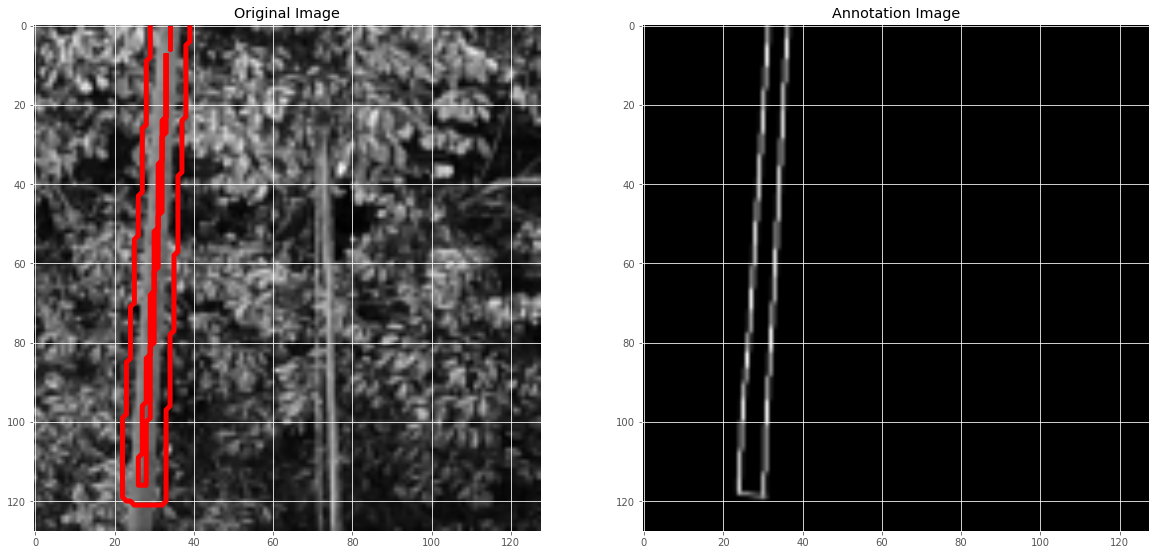

In [12]:
# Visualize any random image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # powerline indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if powerline
    # draw a boundary(contour) in the original image separating powerline and non-powerline areas
    ax1.contour(y_train[ix].squeeze(), colors = 'r', linewidths = 5, levels = [0.5])
ax1.set_title('Original Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Annotation Image')

In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [14]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [15]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

                                                                                                  
 batch_normalization_13 (BatchN  (None, 32, 32, 64)  256         ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 32, 32, 64)   0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 64, 64, 32)  18464       ['activation_13[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_2 (Concatenate)    (None, 64, 64, 64)   0           ['conv2d_transpose_2[0][0]',     
          

In [17]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-powerline.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [18]:
results = model.fit(X_train, y_train, batch_size=10, epochs=1000, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 0.5125 - accuracy: 0.7396
Epoch 1: val_loss improved from inf to 0.61254, saving model to model-tgs-powerline.h5
3/3 [==============================] - 7s 975ms/step - loss: 0.5125 - accuracy: 0.7396 - val_loss: 0.6125 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 0.4728 - accuracy: 0.7918
Epoch 2: val_loss improved from 0.61254 to 0.59940, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 754ms/step - loss: 0.4728 - accuracy: 0.7918 - val_loss: 0.5994 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8260
Epoch 3: val_loss improved from 0.59940 to 0.58855, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 902ms/step - loss: 0.4462 - accuracy: 0.8260 - val_loss: 0.5885 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 4/1000
3/3 [=====

3/3 [==============================] - 2s 642ms/step - loss: 0.1727 - accuracy: 0.8801 - val_loss: 0.2429 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 28/1000
3/3 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.8800
Epoch 28: val_loss did not improve from 0.18013
3/3 [==============================] - 2s 653ms/step - loss: 0.1680 - accuracy: 0.8800 - val_loss: 0.1879 - val_accuracy: 0.8966 - lr: 0.0010
Epoch 29/1000
3/3 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.8801
Epoch 29: val_loss improved from 0.18013 to 0.15309, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 687ms/step - loss: 0.1631 - accuracy: 0.8801 - val_loss: 0.1531 - val_accuracy: 0.8963 - lr: 0.0010
Epoch 30/1000
3/3 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.8801
Epoch 30: val_loss improved from 0.15309 to 0.10910, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 697ms/step - lo

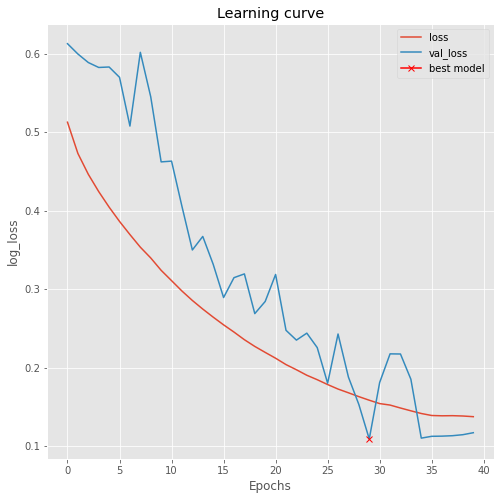

In [19]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

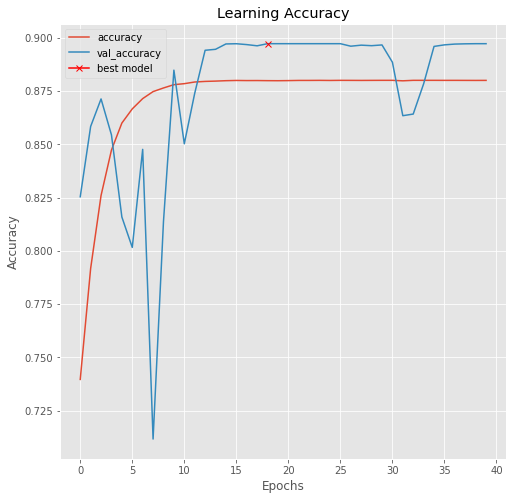

In [20]:
plt.figure(figsize=(8, 8))
plt.title("Learning Accuracy")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [21]:
# load the best model
model.load_weights('model-tgs-powerline.h5')

In [22]:
# Evaluate on validation set (this must be equal to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 82ms/step - loss: 0.1091 - accuracy: 0.8967


[0.10910043120384216, 0.8966878056526184]

### Result : - 
#### For best model : Loss - 0.1091 and Accuracy - 0.8967

In [23]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 0s 65ms/step


In [24]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [25]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[0].set_title('gray')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Powerline')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[2].set_title('Powerline Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[3].set_title('Powerline Predicted binary');

C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])


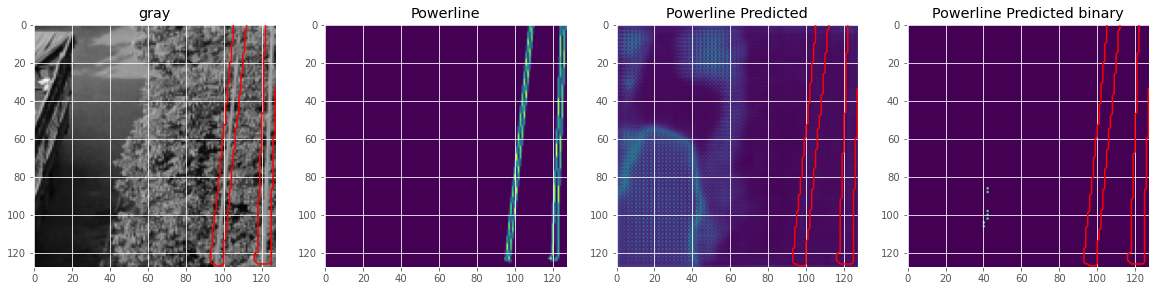

In [26]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=len(y_train)-1)

C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])


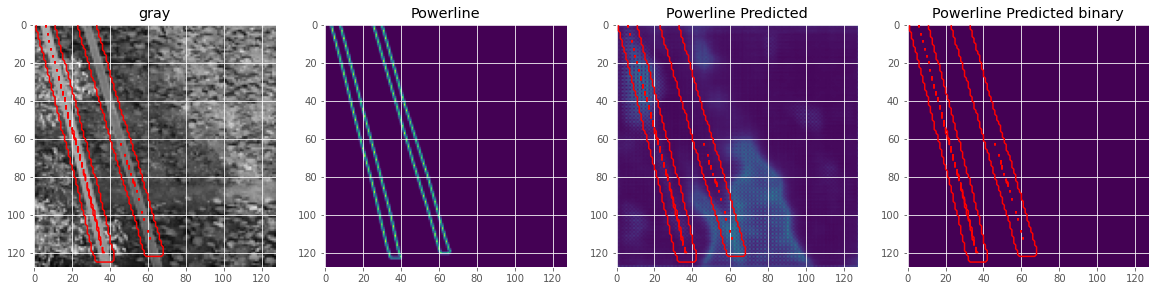

In [27]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])


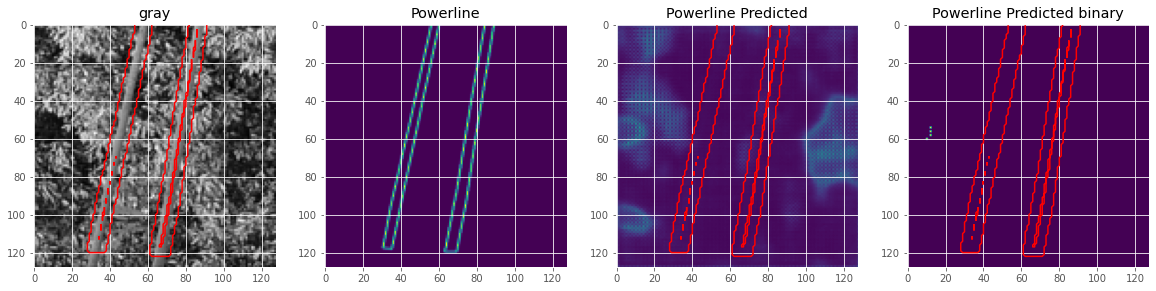

In [28]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=2)

C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])


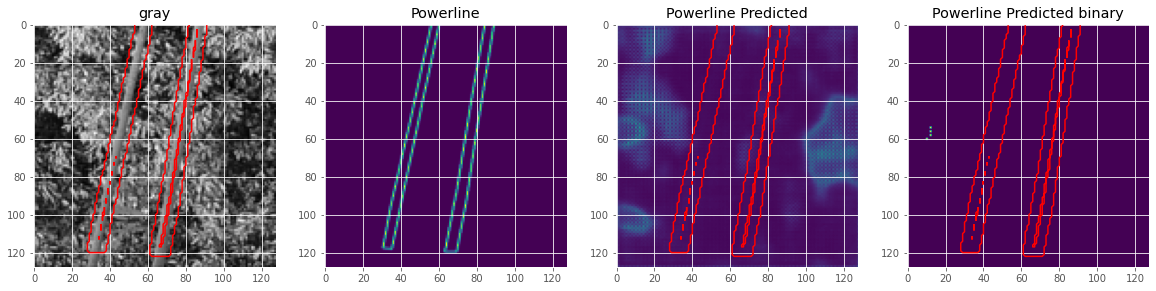

In [29]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

# Experiments

### 1. Change the optimizer learning rate of the Adam optimizer to 1e-4

In [30]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [31]:
results = model.fit(X_train, y_train, batch_size=10, epochs=1000, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 0.8870 - accuracy: 0.3752
Epoch 1: val_loss did not improve from 0.10910
3/3 [==============================] - 7s 900ms/step - loss: 0.8870 - accuracy: 0.3752 - val_loss: 0.6893 - val_accuracy: 0.4164 - lr: 1.0000e-04
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.3789
Epoch 2: val_loss did not improve from 0.10910
3/3 [==============================] - 2s 658ms/step - loss: 0.8767 - accuracy: 0.3789 - val_loss: 0.6741 - val_accuracy: 0.4984 - lr: 1.0000e-04
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 0.8692 - accuracy: 0.3789
Epoch 3: val_loss did not improve from 0.10910
3/3 [==============================] - 2s 636ms/step - loss: 0.8692 - accuracy: 0.3789 - val_loss: 0.6635 - val_accuracy: 0.5637 - lr: 1.0000e-04
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 0.8619 - accuracy: 0.3779
Epoch 4: val_loss did not improve from 0.1091

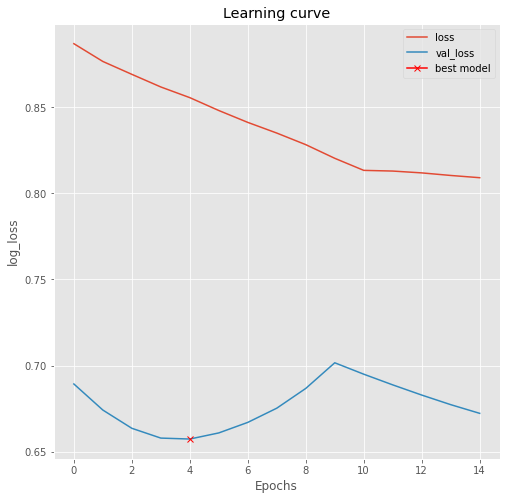

In [32]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

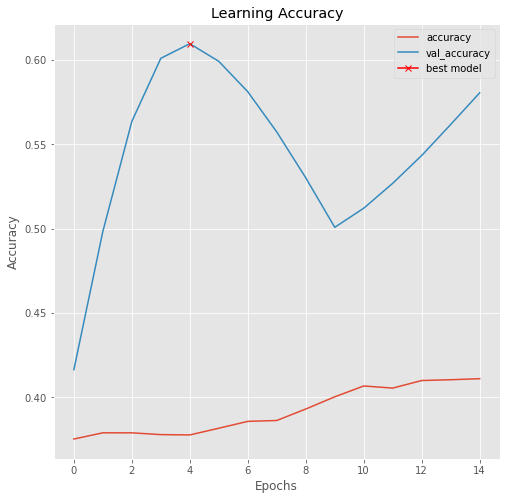

In [33]:
plt.figure(figsize=(8, 8))
plt.title("Learning Accuracy")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [34]:
# load the best model
model.load_weights('model-tgs-powerline.h5')

# Evaluate on validation set (this must be equal to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 110ms/step - loss: 0.1091 - accuracy: 0.8967


[0.10910043120384216, 0.8966878056526184]

### On changing learning rate to 1e-4 - 
#### a. It took less number of epochs to train the model
#### b. For best model : Loss - 0.1091 and Accuracy - 0.8967

### 2. Change the optimizer to SGD

In [35]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["accuracy"])

### 2.1 Train the model for 100 epochs

In [36]:
results = model.fit(X_train, y_train, batch_size=10, epochs=100, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.5373
Epoch 1: val_loss did not improve from 0.10910
3/3 [==============================] - 5s 903ms/step - loss: 0.6635 - accuracy: 0.5373 - val_loss: 0.7512 - val_accuracy: 0.1971 - lr: 0.0100
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.6394 - accuracy: 0.5615
Epoch 2: val_loss did not improve from 0.10910
3/3 [==============================] - 2s 644ms/step - loss: 0.6394 - accuracy: 0.5615 - val_loss: 0.7361 - val_accuracy: 0.2715 - lr: 0.0100
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.5847
Epoch 3: val_loss did not improve from 0.10910
3/3 [==============================] - 2s 660ms/step - loss: 0.6170 - accuracy: 0.5847 - val_loss: 0.7217 - val_accuracy: 0.3496 - lr: 0.0100
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 0.5957 - accuracy: 0.6066
Epoch 4: val_loss did not improve from 0.10910
3/3 [=========

Epoch 30/100
3/3 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.8605
Epoch 30: val_loss did not improve from 0.10910
3/3 [==============================] - 3s 818ms/step - loss: 0.2957 - accuracy: 0.8605 - val_loss: 0.4432 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 31/100
3/3 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.8629
Epoch 31: val_loss did not improve from 0.10910
3/3 [==============================] - 2s 738ms/step - loss: 0.2895 - accuracy: 0.8629 - val_loss: 0.4348 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 32/100
3/3 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.8644
Epoch 32: val_loss did not improve from 0.10910
3/3 [==============================] - 2s 633ms/step - loss: 0.2838 - accuracy: 0.8644 - val_loss: 0.4264 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 33/100
3/3 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.8656
Epoch 33: val_loss did not improve from 0.10910
3/3 [=

Epoch 59/100
3/3 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.8789
Epoch 59: val_loss did not improve from 0.10910
3/3 [==============================] - 2s 778ms/step - loss: 0.1872 - accuracy: 0.8789 - val_loss: 0.2599 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 60/100
3/3 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.8789
Epoch 60: val_loss did not improve from 0.10910
3/3 [==============================] - 2s 841ms/step - loss: 0.1851 - accuracy: 0.8789 - val_loss: 0.2557 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 61/100
3/3 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.8791
Epoch 61: val_loss did not improve from 0.10910
3/3 [==============================] - 3s 896ms/step - loss: 0.1827 - accuracy: 0.8791 - val_loss: 0.2516 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 62/100
3/3 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.8791
Epoch 62: val_loss did not improve from 0.10910
3/3 [=

Epoch 88/100
3/3 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.8799
Epoch 88: val_loss did not improve from 0.10910
3/3 [==============================] - 2s 711ms/step - loss: 0.1408 - accuracy: 0.8799 - val_loss: 0.1757 - val_accuracy: 0.8972 - lr: 0.0100
Epoch 89/100
3/3 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.8799
Epoch 89: val_loss did not improve from 0.10910
3/3 [==============================] - 2s 705ms/step - loss: 0.1399 - accuracy: 0.8799 - val_loss: 0.1737 - val_accuracy: 0.8972 - lr: 0.0100
Epoch 90/100
3/3 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.8800
Epoch 90: val_loss did not improve from 0.10910
3/3 [==============================] - 2s 762ms/step - loss: 0.1386 - accuracy: 0.8800 - val_loss: 0.1719 - val_accuracy: 0.8972 - lr: 0.0100
Epoch 91/100
3/3 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.8800
Epoch 91: val_loss did not improve from 0.10910
3/3 [=

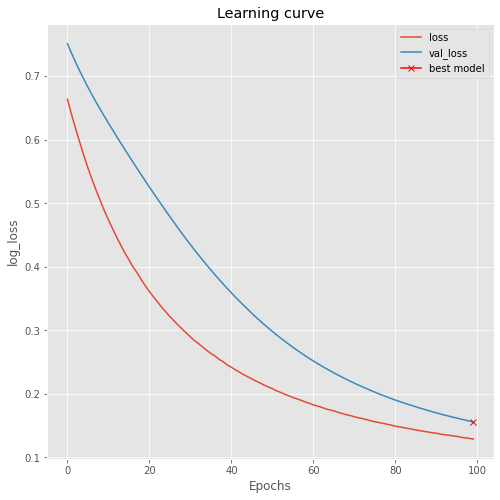

In [37]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

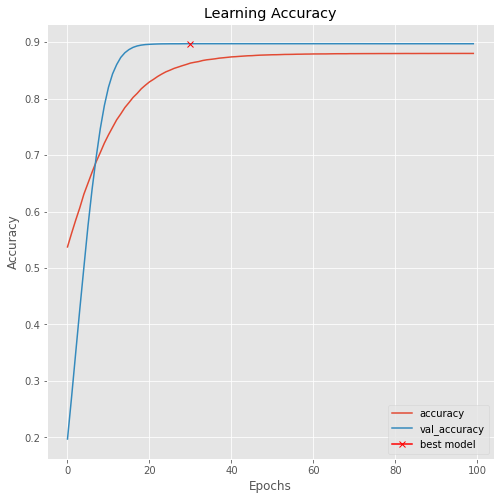

In [38]:
plt.figure(figsize=(8, 8))
plt.title("Learning Accuracy")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [39]:
# load the best model
model.load_weights('model-tgs-powerline.h5')

# Evaluate on validation set (this must be equal to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 68ms/step - loss: 0.1091 - accuracy: 0.8967


[0.10910043120384216, 0.8966878056526184]

### On Changing Optimizer to SGD and training model for 100 epochs - 
#### a. Model did not early stop while training
#### b. For best model : Loss - 0.1091 and Accuracy - 0.8967
#### c. Loss and Accuracy of best model is same as while using Adam optimizer 

### 2.2 Train for 1000 epochs

In [41]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["accuracy"])

In [42]:
results = model.fit(X_train, y_train, batch_size=10, epochs=1000, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 0.7445 - accuracy: 0.4592
Epoch 1: val_loss did not improve from 0.10375
3/3 [==============================] - 5s 839ms/step - loss: 0.7445 - accuracy: 0.4592 - val_loss: 0.6940 - val_accuracy: 0.4357 - lr: 0.0100
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 0.7156 - accuracy: 0.4926
Epoch 2: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 671ms/step - loss: 0.7156 - accuracy: 0.4926 - val_loss: 0.6741 - val_accuracy: 0.5795 - lr: 0.0100
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.5206
Epoch 3: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 657ms/step - loss: 0.6880 - accuracy: 0.5206 - val_loss: 0.6560 - val_accuracy: 0.6988 - lr: 0.0100
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 0.6623 - accuracy: 0.5468
Epoch 4: val_loss did not improve from 0.10375
3/3 [=====

Epoch 30/1000
3/3 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8609
Epoch 30: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 713ms/step - loss: 0.3217 - accuracy: 0.8609 - val_loss: 0.4191 - val_accuracy: 0.8972 - lr: 0.0100
Epoch 31/1000
3/3 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.8630
Epoch 31: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 664ms/step - loss: 0.3154 - accuracy: 0.8630 - val_loss: 0.4131 - val_accuracy: 0.8972 - lr: 0.0100
Epoch 32/1000
3/3 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.8656
Epoch 32: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 645ms/step - loss: 0.3092 - accuracy: 0.8656 - val_loss: 0.4074 - val_accuracy: 0.8972 - lr: 0.0100
Epoch 33/1000
3/3 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.8666
Epoch 33: val_loss did not improve from 0.10375
3/

Epoch 59/1000
3/3 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.8794
Epoch 59: val_loss did not improve from 0.10375
3/3 [==============================] - 3s 847ms/step - loss: 0.2010 - accuracy: 0.8794 - val_loss: 0.2752 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 60/1000
3/3 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.8794
Epoch 60: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 796ms/step - loss: 0.1982 - accuracy: 0.8794 - val_loss: 0.2713 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 61/1000
3/3 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.8795
Epoch 61: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 792ms/step - loss: 0.1956 - accuracy: 0.8795 - val_loss: 0.2675 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 62/1000
3/3 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.8796
Epoch 62: val_loss did not improve from 0.10375
3/

Epoch 88/1000
3/3 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.8800
Epoch 88: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 703ms/step - loss: 0.1489 - accuracy: 0.8800 - val_loss: 0.1904 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 89/1000
3/3 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.8800
Epoch 89: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 716ms/step - loss: 0.1479 - accuracy: 0.8800 - val_loss: 0.1883 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 90/1000
3/3 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.8800
Epoch 90: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 703ms/step - loss: 0.1467 - accuracy: 0.8800 - val_loss: 0.1862 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 91/1000
3/3 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.8800
Epoch 91: val_loss did not improve from 0.10375
3/

Epoch 117/1000
3/3 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.8801
Epoch 117: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 801ms/step - loss: 0.1224 - accuracy: 0.8801 - val_loss: 0.1438 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 118/1000
3/3 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.8801
Epoch 118: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 793ms/step - loss: 0.1212 - accuracy: 0.8801 - val_loss: 0.1426 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 119/1000
3/3 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.8801
Epoch 119: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 786ms/step - loss: 0.1207 - accuracy: 0.8801 - val_loss: 0.1415 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 120/1000
3/3 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.8801
Epoch 120: val_loss did not improve from 0.

Epoch 146/1000
3/3 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.8801
Epoch 146: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 791ms/step - loss: 0.1058 - accuracy: 0.8801 - val_loss: 0.1168 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 147/1000
3/3 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.8801
Epoch 147: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 772ms/step - loss: 0.1055 - accuracy: 0.8801 - val_loss: 0.1161 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 148/1000
3/3 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.8801
Epoch 148: val_loss did not improve from 0.10375
3/3 [==============================] - 2s 787ms/step - loss: 0.1049 - accuracy: 0.8801 - val_loss: 0.1154 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 149/1000
3/3 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.8801
Epoch 149: val_loss did not improve from 0.

Epoch 174/1000
3/3 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.8801
Epoch 174: val_loss improved from 0.10159 to 0.10117, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 815ms/step - loss: 0.0961 - accuracy: 0.8801 - val_loss: 0.1012 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 175/1000
3/3 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.8801
Epoch 175: val_loss improved from 0.10117 to 0.10074, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 761ms/step - loss: 0.0958 - accuracy: 0.8801 - val_loss: 0.1007 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 176/1000
3/3 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.8801
Epoch 176: val_loss improved from 0.10074 to 0.10030, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 753ms/step - loss: 0.0956 - accuracy: 0.8801 - val_loss: 0.1003 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 1

Epoch 199/1000
3/3 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.8801
Epoch 199: val_loss improved from 0.09203 to 0.09172, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 864ms/step - loss: 0.0895 - accuracy: 0.8801 - val_loss: 0.0917 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 200/1000
3/3 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.8801
Epoch 200: val_loss improved from 0.09172 to 0.09141, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 863ms/step - loss: 0.0894 - accuracy: 0.8801 - val_loss: 0.0914 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 201/1000
3/3 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.8801
Epoch 201: val_loss improved from 0.09141 to 0.09109, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 859ms/step - loss: 0.0893 - accuracy: 0.8801 - val_loss: 0.0911 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 2

Epoch 224/1000
3/3 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 0.8801
Epoch 224: val_loss improved from 0.08526 to 0.08503, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 948ms/step - loss: 0.0850 - accuracy: 0.8801 - val_loss: 0.0850 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 225/1000
3/3 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 0.8801
Epoch 225: val_loss improved from 0.08503 to 0.08478, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 1s/step - loss: 0.0848 - accuracy: 0.8801 - val_loss: 0.0848 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 226/1000
3/3 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.8801
Epoch 226: val_loss improved from 0.08478 to 0.08456, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 921ms/step - loss: 0.0845 - accuracy: 0.8801 - val_loss: 0.0846 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 227/

Epoch 249/1000
3/3 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.8801
Epoch 249: val_loss improved from 0.08014 to 0.07996, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 879ms/step - loss: 0.0812 - accuracy: 0.8801 - val_loss: 0.0800 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 250/1000
3/3 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.8801
Epoch 250: val_loss improved from 0.07996 to 0.07978, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 886ms/step - loss: 0.0810 - accuracy: 0.8801 - val_loss: 0.0798 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 251/1000
3/3 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.8801
Epoch 251: val_loss improved from 0.07978 to 0.07961, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 881ms/step - loss: 0.0809 - accuracy: 0.8801 - val_loss: 0.0796 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 2

Epoch 274/1000
3/3 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.8801
Epoch 274: val_loss improved from 0.07615 to 0.07602, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 863ms/step - loss: 0.0784 - accuracy: 0.8801 - val_loss: 0.0760 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 275/1000
3/3 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.8801
Epoch 275: val_loss improved from 0.07602 to 0.07587, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 952ms/step - loss: 0.0782 - accuracy: 0.8801 - val_loss: 0.0759 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 276/1000
3/3 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.8801
Epoch 276: val_loss improved from 0.07587 to 0.07573, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 921ms/step - loss: 0.0781 - accuracy: 0.8801 - val_loss: 0.0757 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 2

Epoch 299/1000
3/3 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.8801
Epoch 299: val_loss improved from 0.07306 to 0.07294, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 770ms/step - loss: 0.0760 - accuracy: 0.8801 - val_loss: 0.0729 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 300/1000
3/3 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.8801
Epoch 300: val_loss improved from 0.07294 to 0.07284, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 770ms/step - loss: 0.0760 - accuracy: 0.8801 - val_loss: 0.0728 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 301/1000
3/3 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.8801
Epoch 301: val_loss improved from 0.07284 to 0.07274, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 753ms/step - loss: 0.0760 - accuracy: 0.8801 - val_loss: 0.0727 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 3

Epoch 324/1000
3/3 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.8801
Epoch 324: val_loss improved from 0.07052 to 0.07042, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 857ms/step - loss: 0.0740 - accuracy: 0.8801 - val_loss: 0.0704 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 325/1000
3/3 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.8801
Epoch 325: val_loss improved from 0.07042 to 0.07033, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 845ms/step - loss: 0.0740 - accuracy: 0.8801 - val_loss: 0.0703 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 326/1000
3/3 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.8801
Epoch 326: val_loss improved from 0.07033 to 0.07023, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 870ms/step - loss: 0.0740 - accuracy: 0.8801 - val_loss: 0.0702 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 3

Epoch 349/1000
3/3 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.8801
Epoch 349: val_loss improved from 0.06837 to 0.06829, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 841ms/step - loss: 0.0724 - accuracy: 0.8801 - val_loss: 0.0683 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 350/1000
3/3 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.8801
Epoch 350: val_loss improved from 0.06829 to 0.06821, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 880ms/step - loss: 0.0726 - accuracy: 0.8801 - val_loss: 0.0682 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 351/1000
3/3 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.8801
Epoch 351: val_loss improved from 0.06821 to 0.06815, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 865ms/step - loss: 0.0725 - accuracy: 0.8801 - val_loss: 0.0681 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 3

Epoch 374/1000
3/3 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.8801
Epoch 374: val_loss improved from 0.06659 to 0.06652, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 867ms/step - loss: 0.0713 - accuracy: 0.8801 - val_loss: 0.0665 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 375/1000
3/3 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.8801
Epoch 375: val_loss improved from 0.06652 to 0.06646, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 828ms/step - loss: 0.0711 - accuracy: 0.8801 - val_loss: 0.0665 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 376/1000
3/3 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.8801
Epoch 376: val_loss improved from 0.06646 to 0.06639, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 811ms/step - loss: 0.0710 - accuracy: 0.8801 - val_loss: 0.0664 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 3

Epoch 399/1000
3/3 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.8801
Epoch 399: val_loss improved from 0.06503 to 0.06499, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 840ms/step - loss: 0.0700 - accuracy: 0.8801 - val_loss: 0.0650 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 400/1000
3/3 [==============================] - ETA: 0s - loss: 0.0698 - accuracy: 0.8801
Epoch 400: val_loss improved from 0.06499 to 0.06494, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 845ms/step - loss: 0.0698 - accuracy: 0.8801 - val_loss: 0.0649 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 401/1000
3/3 [==============================] - ETA: 0s - loss: 0.0698 - accuracy: 0.8801
Epoch 401: val_loss improved from 0.06494 to 0.06488, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 862ms/step - loss: 0.0698 - accuracy: 0.8801 - val_loss: 0.0649 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 4

Epoch 424/1000
3/3 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.8801
Epoch 424: val_loss improved from 0.06374 to 0.06368, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 887ms/step - loss: 0.0690 - accuracy: 0.8801 - val_loss: 0.0637 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 425/1000
3/3 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.8801
Epoch 425: val_loss improved from 0.06368 to 0.06363, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 863ms/step - loss: 0.0689 - accuracy: 0.8801 - val_loss: 0.0636 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 426/1000
3/3 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.8801
Epoch 426: val_loss improved from 0.06363 to 0.06359, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 863ms/step - loss: 0.0692 - accuracy: 0.8801 - val_loss: 0.0636 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 4

Epoch 449/1000
3/3 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.8801
Epoch 449: val_loss improved from 0.06262 to 0.06258, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 880ms/step - loss: 0.0680 - accuracy: 0.8801 - val_loss: 0.0626 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 450/1000
3/3 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.8801
Epoch 450: val_loss improved from 0.06258 to 0.06254, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 846ms/step - loss: 0.0680 - accuracy: 0.8801 - val_loss: 0.0625 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 451/1000
3/3 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.8801
Epoch 451: val_loss improved from 0.06254 to 0.06250, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 840ms/step - loss: 0.0680 - accuracy: 0.8801 - val_loss: 0.0625 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 4

Epoch 474/1000
3/3 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.8801
Epoch 474: val_loss improved from 0.06161 to 0.06157, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 862ms/step - loss: 0.0673 - accuracy: 0.8801 - val_loss: 0.0616 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 475/1000
3/3 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.8801
Epoch 475: val_loss improved from 0.06157 to 0.06153, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 862ms/step - loss: 0.0671 - accuracy: 0.8801 - val_loss: 0.0615 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 476/1000
3/3 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.8801
Epoch 476: val_loss improved from 0.06153 to 0.06149, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 866ms/step - loss: 0.0672 - accuracy: 0.8801 - val_loss: 0.0615 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 4

Epoch 499/1000
3/3 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.8801
Epoch 499: val_loss improved from 0.06072 to 0.06069, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 870ms/step - loss: 0.0665 - accuracy: 0.8801 - val_loss: 0.0607 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 500/1000
3/3 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.8801
Epoch 500: val_loss improved from 0.06069 to 0.06066, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 863ms/step - loss: 0.0664 - accuracy: 0.8801 - val_loss: 0.0607 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 501/1000
3/3 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.8801
Epoch 501: val_loss improved from 0.06066 to 0.06062, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 867ms/step - loss: 0.0665 - accuracy: 0.8801 - val_loss: 0.0606 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 5

Epoch 524/1000
3/3 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.8801
Epoch 524: val_loss improved from 0.05992 to 0.05989, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 876ms/step - loss: 0.0660 - accuracy: 0.8801 - val_loss: 0.0599 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 525/1000
3/3 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.8801
Epoch 525: val_loss improved from 0.05989 to 0.05987, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 869ms/step - loss: 0.0659 - accuracy: 0.8801 - val_loss: 0.0599 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 526/1000
3/3 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.8801
Epoch 526: val_loss improved from 0.05987 to 0.05985, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 861ms/step - loss: 0.0659 - accuracy: 0.8801 - val_loss: 0.0598 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 5

Epoch 549/1000
3/3 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.8801
Epoch 549: val_loss improved from 0.05920 to 0.05917, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 861ms/step - loss: 0.0654 - accuracy: 0.8801 - val_loss: 0.0592 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 550/1000
3/3 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.8801
Epoch 550: val_loss improved from 0.05917 to 0.05914, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 873ms/step - loss: 0.0653 - accuracy: 0.8801 - val_loss: 0.0591 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 551/1000
3/3 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.8801
Epoch 551: val_loss improved from 0.05914 to 0.05911, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 858ms/step - loss: 0.0652 - accuracy: 0.8801 - val_loss: 0.0591 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 5

Epoch 574/1000
3/3 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.8801
Epoch 574: val_loss improved from 0.05854 to 0.05852, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 819ms/step - loss: 0.0648 - accuracy: 0.8801 - val_loss: 0.0585 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 575/1000
3/3 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.8801
Epoch 575: val_loss improved from 0.05852 to 0.05849, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 810ms/step - loss: 0.0649 - accuracy: 0.8801 - val_loss: 0.0585 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 576/1000
3/3 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.8801
Epoch 576: val_loss improved from 0.05849 to 0.05846, saving model to model-tgs-powerline.h5
3/3 [==============================] - 2s 819ms/step - loss: 0.0647 - accuracy: 0.8801 - val_loss: 0.0585 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 5

Epoch 599/1000
3/3 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.8801
Epoch 599: val_loss improved from 0.05793 to 0.05791, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 865ms/step - loss: 0.0644 - accuracy: 0.8801 - val_loss: 0.0579 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 600/1000
3/3 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.8801
Epoch 600: val_loss improved from 0.05791 to 0.05789, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 993ms/step - loss: 0.0642 - accuracy: 0.8801 - val_loss: 0.0579 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 601/1000
3/3 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.8801
Epoch 601: val_loss improved from 0.05789 to 0.05788, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 993ms/step - loss: 0.0643 - accuracy: 0.8801 - val_loss: 0.0579 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 6

3/3 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.8801
Epoch 623: val_loss improved from 0.05757 to 0.05757, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 883ms/step - loss: 0.0640 - accuracy: 0.8801 - val_loss: 0.0576 - val_accuracy: 0.8973 - lr: 1.0000e-04
Epoch 624/1000
3/3 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.8801
Epoch 624: val_loss improved from 0.05757 to 0.05756, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 897ms/step - loss: 0.0641 - accuracy: 0.8801 - val_loss: 0.0576 - val_accuracy: 0.8973 - lr: 1.0000e-04
Epoch 625/1000
3/3 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.8801
Epoch 625: val_loss improved from 0.05756 to 0.05755, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 905ms/step - loss: 0.0641 - accuracy: 0.8801 - val_loss: 0.0576 - val_accuracy: 0.8973 - lr: 1.0000e-04
Epoch 626/

Epoch 648/1000
3/3 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.8801
Epoch 648: val_loss improved from 0.05743 to 0.05742, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 1s/step - loss: 0.0640 - accuracy: 0.8801 - val_loss: 0.0574 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 649/1000
3/3 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.8801
Epoch 649: val_loss did not improve from 0.05742
3/3 [==============================] - 3s 838ms/step - loss: 0.0641 - accuracy: 0.8801 - val_loss: 0.0574 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 650/1000
3/3 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.8801
Epoch 650: val_loss improved from 0.05742 to 0.05742, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 892ms/step - loss: 0.0641 - accuracy: 0.8801 - val_loss: 0.0574 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 651/1000
3/3 [======================

3/3 [==============================] - 3s 890ms/step - loss: 0.0639 - accuracy: 0.8801 - val_loss: 0.0574 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 674/1000
3/3 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.8801
Epoch 674: val_loss improved from 0.05736 to 0.05736, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 870ms/step - loss: 0.0641 - accuracy: 0.8801 - val_loss: 0.0574 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 675/1000
3/3 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.8801
Epoch 675: val_loss improved from 0.05736 to 0.05735, saving model to model-tgs-powerline.h5
3/3 [==============================] - 3s 869ms/step - loss: 0.0641 - accuracy: 0.8801 - val_loss: 0.0574 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 676/1000
3/3 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.8801
Epoch 676: val_loss did not improve from 0.05735
3/3 [==============================] - 

3/3 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.8801
Epoch 699: val_loss improved from 0.05730 to 0.05730, saving model to model-tgs-powerline.h5
3/3 [==============================] - 4s 1s/step - loss: 0.0640 - accuracy: 0.8801 - val_loss: 0.0573 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 700/1000
3/3 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.8801
Epoch 700: val_loss did not improve from 0.05730
3/3 [==============================] - 3s 1s/step - loss: 0.0641 - accuracy: 0.8801 - val_loss: 0.0573 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 701/1000
3/3 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.8801
Epoch 701: val_loss did not improve from 0.05730
3/3 [==============================] - 3s 957ms/step - loss: 0.0640 - accuracy: 0.8801 - val_loss: 0.0573 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 702/1000
3/3 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.8801
Epoch 70

Epoch 725/1000
3/3 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.8801
Epoch 725: val_loss did not improve from 0.05727
3/3 [==============================] - 2s 823ms/step - loss: 0.0642 - accuracy: 0.8801 - val_loss: 0.0573 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 726/1000
3/3 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.8801
Epoch 726: val_loss did not improve from 0.05727
3/3 [==============================] - 2s 803ms/step - loss: 0.0640 - accuracy: 0.8801 - val_loss: 0.0573 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 727/1000
3/3 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.8801
Epoch 727: val_loss did not improve from 0.05727
3/3 [==============================] - 3s 834ms/step - loss: 0.0641 - accuracy: 0.8801 - val_loss: 0.0573 - val_accuracy: 0.8973 - lr: 1.0000e-05
Epoch 728/1000
3/3 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.8801
Epoch 728: val_loss did not imp

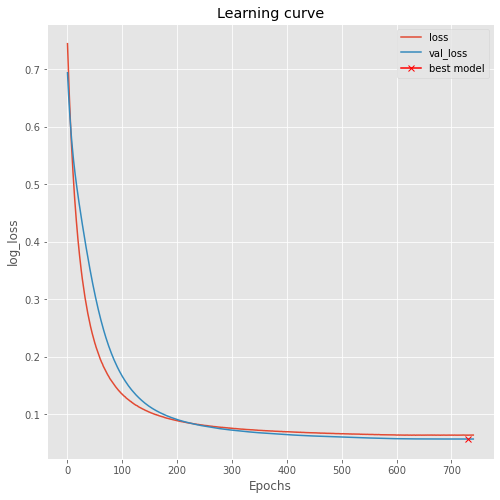

In [43]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

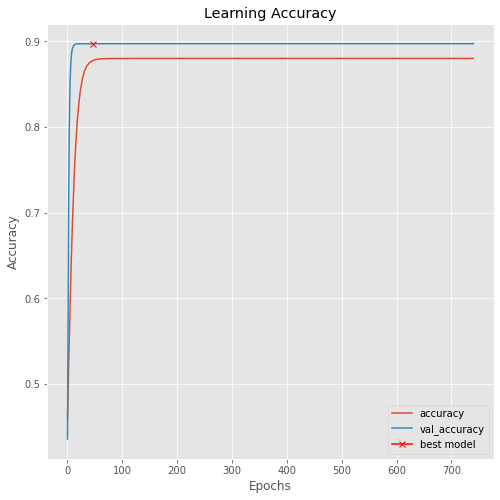

In [44]:
plt.figure(figsize=(8, 8))
plt.title("Learning Accuracy")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [45]:
# load the best model
model.load_weights('model-tgs-powerline.h5')

# Evaluate on validation set (this must be equal to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 70ms/step - loss: 0.0573 - accuracy: 0.8973


[0.05727119371294975, 0.89727783203125]

### On Changing Optimizer to SGD and training model for 1000 epochs - 
#### a. For best model : Loss - 0.0573 and Accuracy - 0.8973 
#### b. Loss for best model has reduced to half as compared with training model for 100 epochs

### 2.3 Binary thresholding of the result. Threshold value of .4

In [46]:
# load the best model
model.load_weights('model-tgs-powerline.h5')

# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.4).astype(np.uint8)
preds_val_t = (preds_val > 0.4).astype(np.uint8)

1/1 [==============================] - 0s 68ms/step


C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])


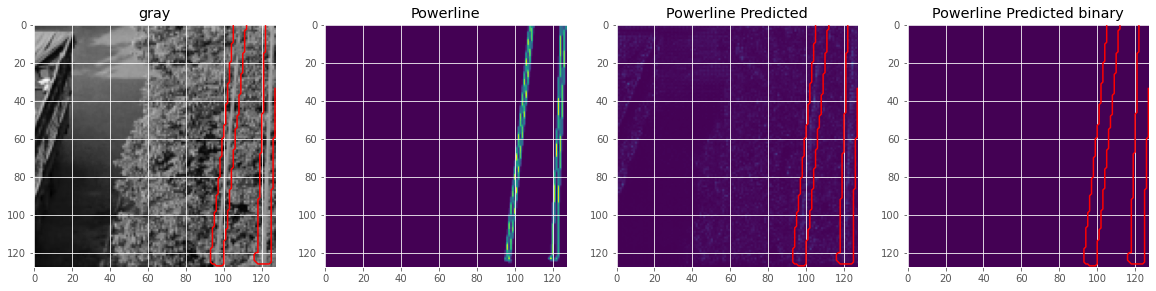

In [47]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=len(y_train)-1)

C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])


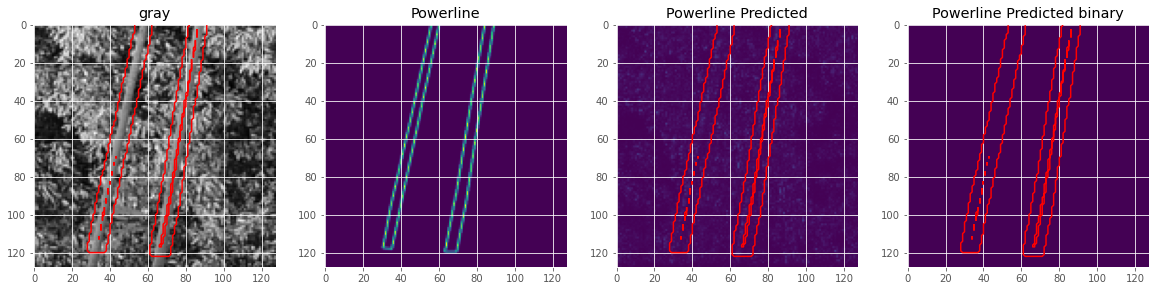

In [48]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=2)

### 2.4 Binary thresholding of the result. Threshold value of .5

In [49]:
# load the best model
model.load_weights('model-tgs-powerline.h5')

# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 87ms/step


C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])


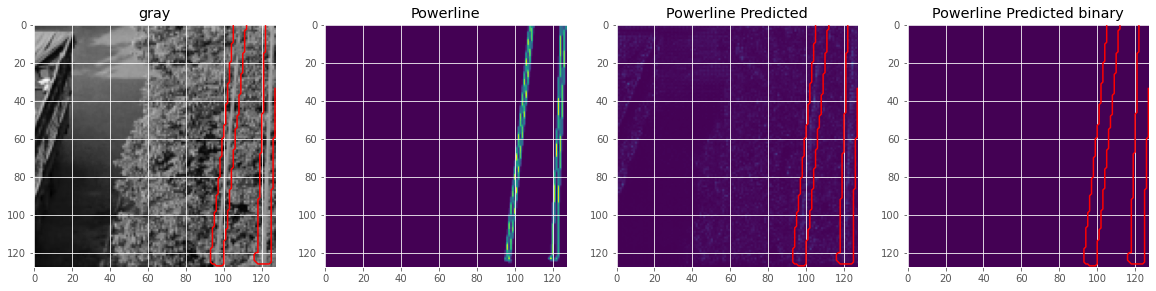

In [50]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=len(y_train)-1)

C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])


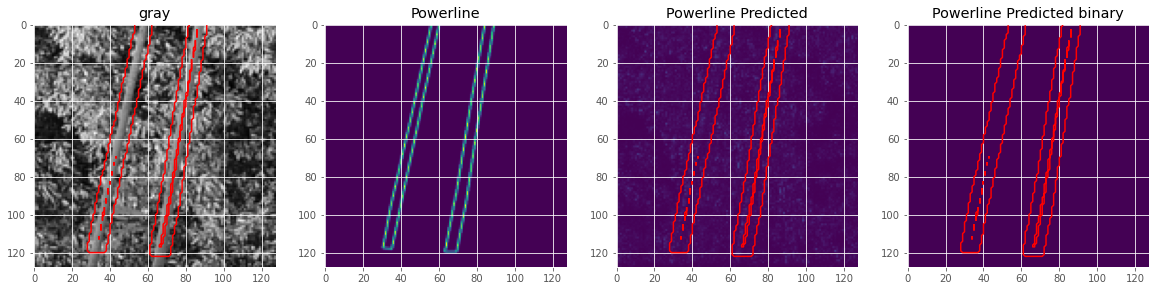

In [51]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=2)

### 2.5 Binary thresholding of the result. Threshold value of .7

In [52]:
# load the best model
model.load_weights('model-tgs-powerline.h5')

# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.7).astype(np.uint8)
preds_val_t = (preds_val > 0.7).astype(np.uint8)

1/1 [==============================] - 0s 84ms/step


C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])


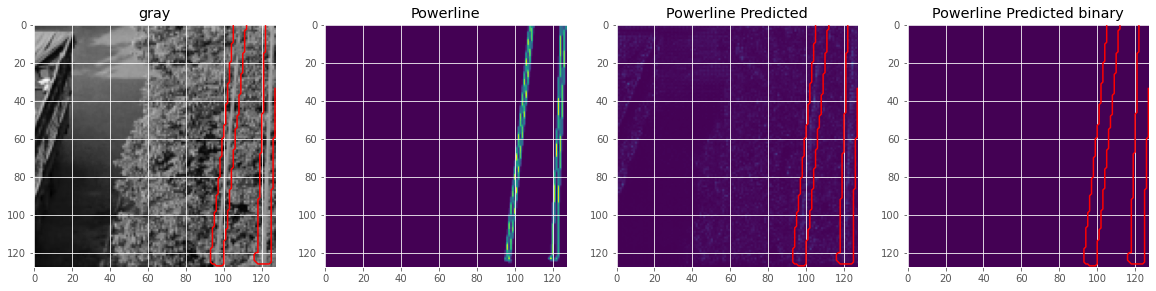

In [53]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=len(y_train)-1)

C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
C:\Users\ankit\AppData\Local\Temp/ipykernel_23640/3777296967.py:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])


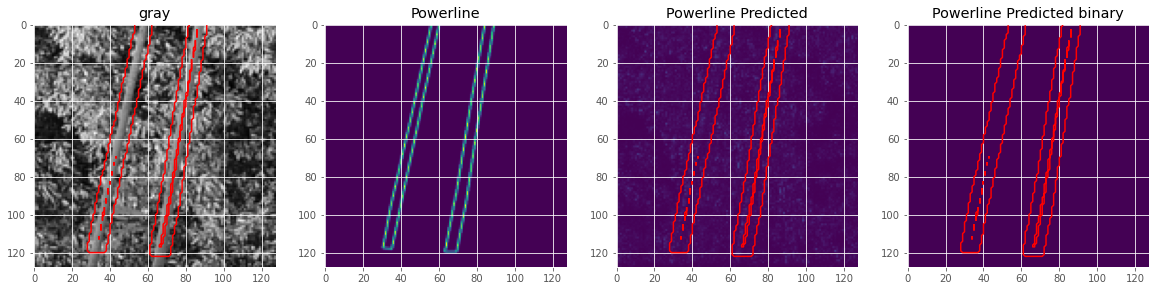

In [54]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=2)

#### Results of binary thresholding (for threshold values of .4, .5, .7 )
##### loss: 0.0573 and accuracy: 0.8973